# *Advanced example* from the docs: gaussian ring

In [1]:
# Configuration
from __future__ import division
%matplotlib inline
import sys, platform, os
try:
    from cobaya.run import run
except ImportError:
    sys.path.insert(0,'../../cobaya')
    from cobaya.run import run

### Defining the *Gaussian ring* likelihood and priors for its parameters

In [2]:
import numpy as np
from scipy import stats

def gauss_ring_logp(x, y):
    return stats.norm.logpdf(np.sqrt(x**2+y**2), loc=1, scale=0.2)

info = {"likelihood": {"ring": gauss_ring_logp}}

In [3]:
from collections import OrderedDict as odict

info["params"] = odict([
    ["x", {"prior": {"min": -2, "max": 2}, "ref": 1, "proposal": 0.2}],
    ["y", {"prior": {"min": -2, "max": 2}, "ref": 0, "proposal": 0.2}]])

### Defining *dynamical* derived parameters: radius and angle

In [4]:
r = "lambda x,y: np.sqrt(x**2+y**2)"
theta = "lambda x,y: np.arctan(y/x)"

info["params"]["r"] = {"derived": r}
info["params"]["theta"] = {"derived": theta, "latex": r"\theta"}

### Sample and plot!

In [5]:
info["sampler"] = {
    "mcmc": {"burn_in": 500, "max_samples": 10000}}

from cobaya.run import run
updated_info, products = run(info)

[output] No output requested. Doing nothing (or returning in scripted call).
[mcmc] Initializing
((1000.0,), (['x', 'y'],), '------')
((1000.0,), (['x', 'y'],))
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (was 2).
[mcmc] Sampling with covariance matrix:
[mcmc] array([[0.04, 0.  ],
       [0.  , 0.04]])
[mcmc] Initial point:
    weight  minuslogpost    x    y  derived__r  derived__theta  minuslogprior  \
0     1.0      2.082089  1.0  0.0         1.0             0.0            NaN   

   chi2  chi2__ring  
0   NaN         NaN   
[mcmc] Sampling!(NB: nothing will be printed until 500 burn-in samples have been obtained)
[mcmc] Finished burn-in phase: discarded 500 accepted steps.
[mcmc] Checkpoint: 80 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 160 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 240 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 320 samples accepted.
Removed no burn in
[mcmc] Che

Removed no burn in
[mcmc] Checkpoint: 9920 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 10000 samples accepted.
Removed no burn in
[mcmc] Sampling complete after 10000 accepted steps.


Removed no burn in


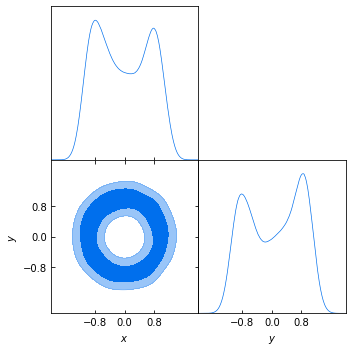

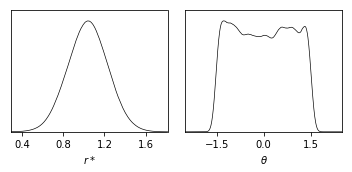

In [6]:
from getdist.mcsamples import loadCobayaSamples
import getdist.plots as gdplt

gdsamples = loadCobayaSamples(updated_info, products["sample"])
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["x", "y"], filled=True)
gdplot.export("example_adv_ring.png")
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.plots_1d(gdsamples, ["r", "theta"], nx=2)
gdplot.export("example_adv_r_theta.png")

### Imposing $x>y$

In [7]:
info["prior"] = {"xGTy": lambda x,y: np.log(x>y)}

from cobaya.run import run
updated_info_xGTy, products_xGTy = run(info)

[output] No output requested. Doing nothing (or returning in scripted call).
[prior] *WARNING* External prior 'xGTy' loaded. Mind that it might not be normalized!
[mcmc] Initializing
((1000.0,), (['x', 'y'],), '------')
((1000.0,), (['x', 'y'],))
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (was 2).
[mcmc] Sampling with covariance matrix:
[mcmc] array([[0.04, 0.  ],
       [0.  , 0.04]])
[mcmc] Initial point:
    weight  minuslogpost    x    y  derived__r  derived__theta  minuslogprior  \
0     1.0      2.082089  1.0  0.0         1.0             0.0            NaN   

   chi2  chi2__ring  
0   NaN         NaN   
[mcmc] Sampling!(NB: nothing will be printed until 500 burn-in samples have been obtained)


/home/jesus/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


[mcmc] Finished burn-in phase: discarded 500 accepted steps.
[mcmc] Checkpoint: 80 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 160 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 240 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 320 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 400 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 480 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 560 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 640 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 720 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 800 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 880 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 960 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 1040 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 1120 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 1200 samples accepted.
Removed no burn in
[mcmc] Checkpoint: 1280 samples accep

Removed no burn in


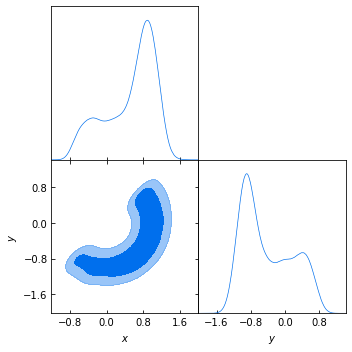

In [8]:
gdsamples_xGTy = loadCobayaSamples(
    updated_info_xGTy, products_xGTy["sample"])
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples_xGTy, ["x", "y"], filled=True)
gdplot.export("example_adv_half.png")

## Alternative: $r$ and $\theta$ as derived parameters of the likelihood

In [ ]:
# List available derived paramters in the default value of the `derived` keyword
def gauss_ring_logp_with_derived(x, y, derived=["r", "theta"]):
    r = np.sqrt(x**2+y**2)
    # Assuming `derived` is passed at runtime as a dictionary to be filled
    derived["r"] = r
    derived["theta"] = np.arctan(y/x)
    return stats.norm.logpdf(r, loc=1, scale=0.2)

# Now we don't need to *define* (but do need to *mention*) r or theta
info_alt = {"likelihood": {"ring": gauss_ring_logp_with_derived}}
info_alt["params"] = odict([
    ["x", {"prior": {"min": -2, "max": 2}, "ref": 1, "proposal": 0.2}],
    ["y", {"prior": {"min": -2, "max": 2}, "ref": 0, "proposal": 0.2}],
    ["r", None],
    ["theta", {"latex": r"\theta"}]])
info_alt["prior"] = {"xGTy": lambda x,y: np.log(x>y)}

In [ ]:
info_alt["sampler"] = info["sampler"]
updated_info_alt, products_alt = run(info_alt)
gdsamples_alt = loadCobayaSamples(
    updated_info_alt, products_alt["sample"])
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples_alt, ["x", "y"], filled=True)
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.plots_1d(gdsamples_alt, ["r", "theta"], nx=2)

## Alternative: sampling on $r$ and $\theta$ instead

In [ ]:
from copy import deepcopy
info_rtheta = deepcopy(info)
info_rtheta["params"] = odict([
    ["r", {"prior": {"min": 0, "max": 2}, "ref": 1,
           "proposal": 0.5, "drop": True}],
    ["theta", {"prior": {"min": -0.75*np.pi, "max": np.pi/4}, "ref": 0,
               "proposal": 0.5, "latex": r"\theta", "drop": True}],
    ["x", "lambda r,theta: r*np.cos(theta)"],
    ["y", "lambda r,theta: r*np.sin(theta)"],
    ["xprime", {"derived": "lambda x: x"}],
    ["yprime", {"derived": "lambda y: y"}]])
# The x>y condition is already incorporated in the prior of theta
info_rtheta["prior"].pop("xGTy")

In [ ]:
updated_info_rtheta, products_rtheta = run(info_rtheta)
gdsamples_rtheta = loadCobayaSamples(
    updated_info_rtheta, products_rtheta["sample"])
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples_rtheta, ["xprime", "yprime"], filled=True)
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples_rtheta, ["r", "theta"], filled=True)